<a href="https://colab.research.google.com/github/Dharshu0702/Deepfake-Detection-System-EfficientnetB4/blob/main/DeepfakeDetectionEffB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Install Kaggle & Download Dataset

!pip install -q kaggle

from google.colab import files
import os, shutil

print("📂 Please upload your kaggle.json file.")
files.upload()  # upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d examstebi/deep-fake-detection-6k-800-800
!unzip -q deep-fake-detection-6k-800-800.zip -d data/

!ls data/6k_800_800/


📂 Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/examstebi/deep-fake-detection-6k-800-800
License(s): unknown
  0% 0.00/72.2M [00:00<?, ?B/s]
100% 72.2M/72.2M [00:00<00:00, 991MB/s]
Test  Train  Valiadation


In [ ]:
# 2. Import Libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
import shutil

In [ ]:
!pip install streamlit
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
!pip install -q tensorflow matplotlib

In [ ]:
# 3. Setup Paths & Split Train/Validation

original_train_dir = '/content/data/6k_800_800/Train'
train_dir = '/content/data/train'
val_dir = '/content/data/val'

# Clean split dirs if exist
for d in [train_dir, val_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

# Split into 80% train / 20% val
for cls in ["Fake", "Real"]:
    cls_path = os.path.join(original_train_dir, cls)
    files = os.listdir(cls_path)
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, cls))
    os.makedirs(os.path.join(val_dir, cls))

    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(train_dir, cls, f))
    for f in val_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(val_dir, cls, f))

print("Dataset split complete!")



Dataset split complete!


In [ ]:
# 4. Data Generators with Strong Augmentation

IMG_SIZE = 224
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4]
).flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="binary"
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="binary"
)


Found 5120 images belonging to 2 classes.
Found 1280 images belonging to 2 classes.


In [ ]:
# 5. Handle Class Imbalance with Weights

counter = Counter(train_gen.classes)  # {0: num_fake, 1: num_real}
majority = max(counter.values())
class_weight = {cls: majority/count for cls, count in counter.items()}
print("Class Weights:", class_weight)



Class Weights: {np.int32(0): 1.0, np.int32(1): 1.0}


In [ ]:
# 6. Build Model (EfficientNetB4) - Updated

base_model = EfficientNetB4(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # freeze initially

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=optimizers.Adam(1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 18,157,792 (69.27 MB)

 Trainable params: 479,745 (1.83 MB)

 Non-trainable params: 17,678,047 (67.44 MB)

In [ ]:
# 7. Callback
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
]

print("Train samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)


Train samples: 5120
Validation samples: 1280


In [ ]:
# 8. Training Stage 1 (Frozen Base)
# ====================================================
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weight,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 140s 558ms/step - accuracy: 0.4858 - loss: 0.9782 - val_accuracy: 0.5000 - val_loss: 0.6928 - learning_rate: 1.0000e-04
Epoch 2/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 77s 483ms/step - accuracy: 0.5137 - loss: 0.8777 - val_accuracy: 0.5000 - val_loss: 0.6918 - learning_rate: 1.0000e-04
Epoch 3/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 477ms/step - accuracy: 0.5004 - loss: 0.8673 - val_accuracy: 0.5016 - val_loss: 0.6883 - learning_rate: 1.0000e-04
Epoch 4/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 77s 482ms/step - accuracy: 0.5206 - loss: 0.8271 - val_accuracy: 0.5297 - val_loss: 0.6855 - learning_rate: 1.0000e-04
Epoch 5/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 78s 490ms/step - accuracy: 0.4951 - loss: 0.8356 - val_accuracy: 0.5266 - val_loss: 0.6848 - learning_rate: 1.0000e-04
Epoch 6/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 75s 469ms/step - accuracy: 0.5123 - loss: 0.8005 - val_accuracy: 0.5297 - val_loss: 0.6858 - learning_rate: 1.0000e-04
Epoch 7/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 76s 4

In [ ]:
# 9. Fine-tuning (Unfreeze last 50% of EfficientNet)

for layer in base_model.layers[:len(base_model.layers)//2]:
    layer.trainable = False
for layer in base_model.layers[len(base_model.layers)//2:]:
    layer.trainable = True

model.compile(optimizer=optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 183s 572ms/step - accuracy: 0.4953 - loss: 0.8622 - val_accuracy: 0.4953 - val_loss: 0.7092 - learning_rate: 1.0000e-05
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 506ms/step - accuracy: 0.5123 - loss: 0.8437 - val_accuracy: 0.4773 - val_loss: 0.7287 - learning_rate: 1.0000e-05
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 515ms/step - accuracy: 0.5276 - loss: 0.8068 - val_accuracy: 0.5492 - val_loss: 0.6895 - learning_rate: 1.0000e-05
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 508ms/step - accuracy: 0.5156 - loss: 0.8143 - val_accuracy: 0.5906 - val_loss: 0.6664 - learning_rate: 1.0000e-05
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 505ms/step - accuracy: 0.5319 - loss: 0.8165 - val_accuracy: 0.6070 - val_loss: 0.6611 - learning_rate: 1.0000e-05
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 505ms/step - accuracy: 0.5421 - loss: 0.8037 - val_accuracy: 0.6016 - val_loss: 0.6573 - learning_rate: 1.0000e-05
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 5

In [ ]:
# 10. Final Evaluation

loss, acc = model.evaluate(val_gen)
print(f" Final Validation Accuracy: {acc:.2%}")

model.save("efficientnetB4_deepfake.h5")

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.7029 - loss: 0.5809


 Final Validation Accuracy: 71.02%


In [ ]:

# Step 1: Install dependencies

#!pip install -q tensorflow matplotlib


# Step 2: Import required libraries

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Step 3: Upload your trained .h5 model file

print("📂 Please upload your trained model (efficientnetB4_deepfake.h5)")
uploaded = files.upload()

model_path = list(uploaded.keys())[0]
model = load_model(model_path)
print("✅ Model loaded successfully!")



📂 Please upload your trained model (efficientnetB4_deepfake.h5)


Saving efficientnetB4_deepfake.h5 to efficientnetB4_deepfake (1).h5


✅ Model loaded successfully!


📂 Please upload an image to classify (Real/Fake)


Saving elon2.jpeg to elon2.jpeg


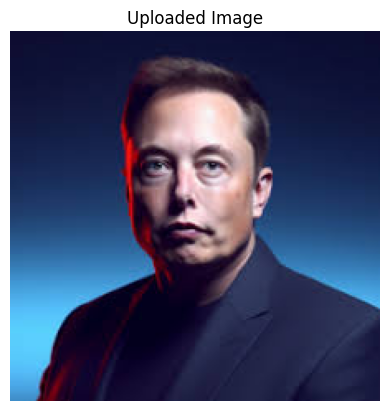

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
 Prediction Result:
 Class: Fake
 Confidence: 50.72%


In [ ]:
# Step 4: Upload an image for prediction
print("📂 Please upload an image to classify (Real/Fake)")
uploaded_image = files.upload()
img_path = list(uploaded_image.keys())[0]

# Step 5: Load & preprocess the image
IMG_SIZE = (224, 224)

img = image.load_img(img_path, target_size=IMG_SIZE)
plt.imshow(img)
plt.title("Uploaded Image")
plt.axis('off')
plt.show()

# Convert to array & normalize
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

# Step 6: Run Prediction
pred = model.predict(x)[0][0]  # single output for binary classification

# Step 7: Interpret results
class_names = {0: "Fake", 1: "Real"}
predicted_class = int(pred >= 0.5)
confidence = pred if predicted_class == 1 else 1 - pred

print(" Prediction Result:")

print(f" Class: {class_names[predicted_class]}")
print(f" Confidence: {confidence*100:.2f}%")
